In [1]:
# -*- encoding: utf-8 -*-
from matplotlib.font_manager import FontProperties
# 设置中文字体，fname是我的电脑中的字体的路径


import IPython.display as display
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from models import ConvolutionalBlock, ResidualBlock
from torch import nn
import hickle as hkl
import matplotlib
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
torch.cuda.set_device(3)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model 3840
epoch = '3840'
model_path = "./model/best_checkpoint_epoch" + str(epoch) + ".pth"
data_path = './data/K562/test_data_half.hkl'


In [2]:
class testDataset(Dataset):
    def __init__(self):
        lo, hi, distance_chrome = hkl.load(data_path)
        lo = lo.squeeze()
        hi = hi.squeeze()
        lo = np.expand_dims(lo,axis=1)
        hi = np.expand_dims(hi,axis=1)
        self.sample_list = []
        for i in range(len(lo)):
            lr = lo[i]
            hr = hi[i]
            dist = abs(distance_chrome[i][0])
            label_one_hot = torch.zeros(5)
            label_one_hot[-int(dist/40)]=1
            chrom = distance_chrome[i][1]
            self.sample_list.append([lr, hr, label_one_hot, dist, chrom])
        print("dataset loaded : " + str(len(lo)) + '*' + str(len(lo[0])) + '*' + str(len(lo[0][0])) + '*' + str(len(lo[0][0][0])))

    def __getitem__(self, i):
        (lr_img, hr_img, label_one_hot, distance, chromosome) = self.sample_list[i]
        return lr_img, hr_img, label_one_hot, distance, chromosome

    def __len__(self):
        return len(self.sample_list)
    
class Generator(nn.Module):
    def __init__(self, kernel_size=3, n_channels=64, n_blocks=5):
        super(Generator, self).__init__()

        # 第一个卷积块
        self.conv_block1 = ConvolutionalBlock(in_channels=6, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=False, activation='relu')

        # 一系列残差模块, 每个残差模块包含一个跳连
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # 第二个卷积块
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

        # 最后3个卷积模块
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=128, kernel_size=kernel_size,
                                              batch_norm=False, activation=None)
        self.conv_block4 = ConvolutionalBlock(in_channels=128, out_channels=256, kernel_size=kernel_size,
                                              batch_norm=False, activation=None)
        self.conv_block5 = ConvolutionalBlock(in_channels=256, out_channels=1, kernel_size=1,
                                              batch_norm=False, activation='tanh')

    def forward(self, lr_imgs):
        output = self.conv_block1(lr_imgs)  # (batch_size, 1, 40, 40)
        residual = output
        output = self.residual_blocks(output)
        output = self.conv_block2(output)
        output = output + residual
        output = self.conv_block3(output)
        output = self.conv_block4(output)
        sr_imgs = self.conv_block5(output)
        return sr_imgs

def make_input(imgs, distances): #imgs batchsize*1*40*40     distances batchsize*5
    dis = distances.unsqueeze(2).unsqueeze(3)
    dis = dis.repeat(1,1,40,40)
    data_input = torch.cat((imgs,dis),1)
    return data_input

In [3]:
checkpoint = torch.load(model_path)
test_dataset = testDataset()
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=1,
                                               pin_memory=True)
generator = Generator(kernel_size=3,n_channels=64,n_blocks=5)
generator = generator.to(device)
generator.load_state_dict(checkpoint['generator'])
generator = generator.eval()
mse_loss_criterion = nn.MSELoss()
mse_loss_criterion = mse_loss_criterion.to(device)

dataset loaded : 2997*1*40*40


In [4]:
ave_mse = []
MSE_0 = []
MSE_40 = []
MSE_80 = []
MSE_120 = []
MSE_160 = []
ave_psnr = []
PSNR_0 = []
PSNR_40 = []
PSNR_80 = []
PSNR_120 = []
PSNR_160 = []
ave_ssim = []
SSIM_0 = []
SSIM_40 = []
SSIM_80 = []
SSIM_120 = []
SSIM_160 = []
for i, (lr_img, hr_img, label, distance, chrom) in enumerate(test_loader):
    display.clear_output(wait=True)
    print("***开始测试***")
    print("正在处理样本 ： " + str(i+1) + "/"+str(len(test_dataset)))
    print("MSE_AVG = " + str(np.mean(ave_mse))  + "  PSNR_AVG = " + str(np.mean(ave_psnr))+ "  SSIM_AVG = " + str(np.mean(ave_ssim)))
    print("MSE_0   = " + str(np.mean(MSE_0))  + "  PSNR_0   = " + str(np.mean(PSNR_0))+ "  SSIM_0   = " + str(np.mean(SSIM_0)))
    print("MSE_40  = " + str(np.mean(MSE_40)) + "  PSNR_40  = " + str(np.mean(PSNR_40))+ "  SSIM_40  = " + str(np.mean(SSIM_40)))
    print("MSE_80  = " + str(np.mean(MSE_80)) + "  PSNR_80  = " + str(np.mean(PSNR_80))+ "  SSIM_80  = " + str(np.mean(SSIM_80)))
    print("MSE_120 = " + str(np.mean(MSE_120))+ "  PSNR_120 = " + str(np.mean(PSNR_120))+ "  SSIM_120 = " + str(np.mean(SSIM_120)))
    print("MSE_160 = " + str(np.mean(MSE_160))+ "  PSNR_160 = " + str(np.mean(PSNR_160))+ "  SSIM_160 = " + str(np.mean(SSIM_160)))

    lr_img = lr_img.type(torch.FloatTensor).to(device)
    hr_img = hr_img.type(torch.FloatTensor).to(device)
    label = label.to(device)
    G_input = make_input(lr_img, label)
    with torch.no_grad():
        sr_img = generator(G_input.detach())
    
    mse = mse_loss_criterion(sr_img , hr_img).to('cpu')
    sr_img = sr_img.squeeze().to("cpu").numpy()
    hr_img = hr_img.squeeze().to("cpu").numpy()

    psnr = peak_signal_noise_ratio(hr_img, sr_img)
    ssim = structural_similarity(hr_img, sr_img)

    ave_mse.append(mse)
    ave_psnr.append(psnr)
    ave_ssim.append(ssim)
    if abs(distance) == 0:
        MSE_0.append(mse)
        PSNR_0.append(psnr)
        SSIM_0.append(ssim)
    elif abs(distance) == 40:
        MSE_40.append(mse)
        PSNR_40.append(psnr)
        SSIM_40.append(ssim)
    elif abs(distance) == 80:
        MSE_80.append(mse)
        PSNR_80.append(psnr)
        SSIM_80.append(ssim)
    elif abs(distance) == 120:
        MSE_120.append(mse)
        PSNR_120.append(psnr)
        SSIM_120.append(ssim)
    elif abs(distance) == 160:
        MSE_160.append(mse)
        PSNR_160.append(psnr)
        SSIM_160.append(ssim)


***开始测试***
正在处理样本 ： 2997/2997
MSE_AVG = 0.032608904  PSNR_AVG = 22.049177346205752  SSIM_AVG = 0.29900220012808426
MSE_0   = 0.012414301  PSNR_0   = 26.267758763445112  SSIM_0   = 0.6422944685348498
MSE_40  = 0.025075084  PSNR_40  = 22.90304003591582  SSIM_40  = 0.3472971943150061
MSE_80  = 0.033285342  PSNR_80  = 21.236113981881317  SSIM_80  = 0.19731360084018967
MSE_120 = 0.046158474  PSNR_120 = 19.704272616612496  SSIM_120 = 0.127260253136065
MSE_160 = 0.052677963  PSNR_160 = 19.10169189843139  SSIM_160 = 0.11049550498028742


In [5]:
display.clear_output(wait=True)
print("***测试结束***")
print("测试集总数：" + str(len(test_dataset)))
print("训练轮数：" + str(epoch) + "   MSE_AVG = " + str(np.mean(ave_mse)))
print("MSE_AVG = " + str(np.mean(ave_mse))[:8]  + "  PSNR_AVG = " + str(np.mean(ave_psnr))[:6]+ "  SSIM_AVG = " + str(np.mean(ave_ssim))[:7])
print("MSE_0   = " + str(np.mean(MSE_0))[:8]  + "  PSNR_0   = " + str(np.mean(PSNR_0))[:6]+ "  SSIM_0   = " + str(np.mean(SSIM_0))[:7])
print("MSE_40  = " + str(np.mean(MSE_40))[:8] + "  PSNR_40  = " + str(np.mean(PSNR_40))[:6]+ "  SSIM_40  = " + str(np.mean(SSIM_40))[:7])
print("MSE_80  = " + str(np.mean(MSE_80))[:8] + "  PSNR_80  = " + str(np.mean(PSNR_80))[:6]+ "  SSIM_80  = " + str(np.mean(SSIM_80))[:7])
print("MSE_120 = " + str(np.mean(MSE_120))[:8]+ "  PSNR_120 = " + str(np.mean(PSNR_120))[:6]+ "  SSIM_120 = " + str(np.mean(SSIM_120))[:7])
print("MSE_160 = " + str(np.mean(MSE_160))[:8]+ "  PSNR_160 = " + str(np.mean(PSNR_160))[:6]+ "  SSIM_160 = " + str(np.mean(SSIM_160))[:7])

***测试结束***
测试集总数：2997
训练轮数：3840   MSE_AVG = 0.032600243
MSE_AVG = 0.032600  PSNR_AVG = 22.051  SSIM_AVG = 0.29913
MSE_0   = 0.012405  PSNR_0   = 26.270  SSIM_0   = 0.64239
MSE_40  = 0.025075  PSNR_40  = 22.903  SSIM_40  = 0.34729
MSE_80  = 0.033285  PSNR_80  = 21.236  SSIM_80  = 0.19731
MSE_120 = 0.046158  PSNR_120 = 19.704  SSIM_120 = 0.12726
MSE_160 = 0.052677  PSNR_160 = 19.101  SSIM_160 = 0.11049


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


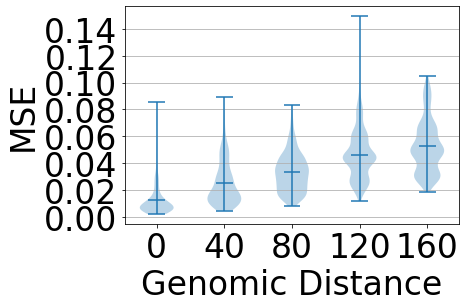

In [23]:
data = [MSE_0, MSE_40, MSE_80, MSE_120, MSE_160]

size_label = 33
size_ticks = 33
plt.violinplot(data,showmeans=True)
plt.xlabel('Genomic Distance',fontsize=size_label)
plt.ylabel('MSE',fontsize=size_label)
plt.xticks(fontsize=size_ticks)
plt.yticks(fontsize=size_ticks)
plt.grid(axis='y')
plt.gca().set_xticklabels(['','0','40','80','120','160'])
matplotlib.pyplot.savefig("./pdf/RST_MSE.pdf", dpi=200, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


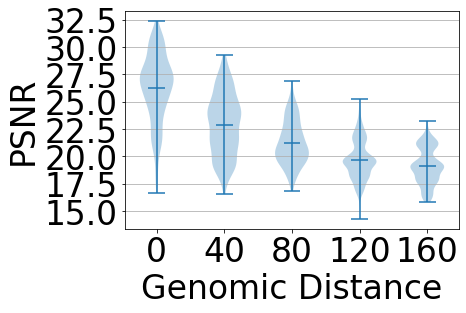

In [24]:
data = [PSNR_0, PSNR_40, PSNR_80, PSNR_120, PSNR_160]
matplotlib.pyplot.savefig("./pdf/RST_PSNR.pdf")
plt.violinplot(data,showmeans=True)
plt.xlabel('Genomic Distance',fontsize=size_label,)
plt.ylabel('PSNR',fontsize=size_label)
plt.xticks(fontsize=size_ticks)
plt.yticks(fontsize=size_ticks)
plt.grid(axis='y')
plt.gca().set_xticklabels(['','0','40','80','120','160'])
matplotlib.pyplot.savefig("./pdf/RST_PSNR.pdf", dpi=200, bbox_inches='tight')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


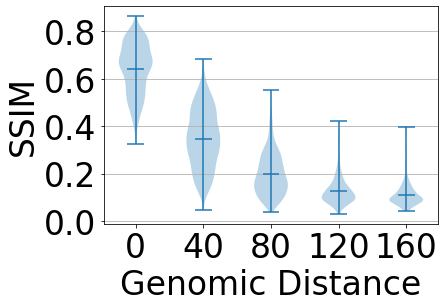

In [25]:
data = [SSIM_0, SSIM_40, SSIM_80, SSIM_120, SSIM_160]
plt.rcParams['font.sans-serif']=['SimHei']
plt.violinplot(data,showmeans=True)
plt.xlabel('Genomic Distance',fontsize=size_label,)
plt.ylabel('SSIM',fontsize=size_label)
plt.xticks(fontsize=size_ticks)
plt.yticks(fontsize=size_ticks)
plt.grid(axis='y')
plt.gca().set_xticklabels(['','0','40','80','120','160'])
matplotlib.pyplot.savefig("./pdf/RST_SSIM.pdf", dpi=200, bbox_inches='tight')